#             Brain Tumor Detection From MRI Images 
                          

# step1:  Importing Libraries

In [1]:
from keras.models import Sequential #for iniatializing 
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
import imutils
import cv2
from matplotlib import pyplot as plt

Using TensorFlow backend.
C:\Users\asus\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\asus\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\asus\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\asus\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519

# Data Preparation & Preprocessing

In order to crop the part that contains only the brain of the image, I used a cropping technique to find the extreme top, bottom, left and right points of the brain. 

In [2]:
def crop_brain_contour(image, plot=False):    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            
    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')    
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    return new_image

In order to better understand what it's doing, let's grab an image from the dataset and apply this cropping function to see the result:

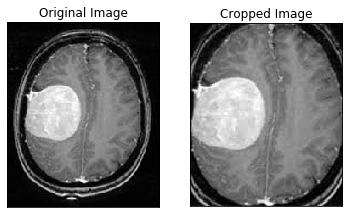

In [3]:
ex_img = cv2.imread(r'C:\Users\asus\Desktop\uploads\dataset\test_set\yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

# Step2: Initializing the model

In [4]:
model=Sequential()

# Step3: Adding Convolution Layers

In [5]:
from keras.preprocessing.image import ImageDataGenerator

In [6]:
model.add(Conv2D(32,3,3,input_shape=(64,64,3),activation='relu'))

C:\Users\asus\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(64, 64, 3..., activation="relu")`
  """Entry point for launching an IPython kernel.


# Step4:Adding Maxpooling Layer

In [7]:
model.add(MaxPooling2D(pool_size=(2,2)))

# Step5: Flatten

In [8]:
model.add(Flatten())

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 30752)             0         
Total params: 896
Trainable params: 896
Non-trainable params: 0
_________________________________________________________________


# Step6 :Ann Layers 

In [10]:
model.add(Dense(units=128,activation='relu',kernel_initializer='random_uniform'))

In [11]:
train_datagen=ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
test_datagen= ImageDataGenerator(rescale=1./255)

In [12]:
model.add(Dense(units=128,activation='relu',kernel_initializer='random_uniform'))

In [13]:
model.add(Dense(units=1,activation='sigmoid',kernel_initializer='random_uniform'))

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 30752)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3936384   
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 3,953,921
Trainable params: 3,953,921
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [16]:
x_train= train_datagen.flow_from_directory(r'C:\Users\asus\Desktop\dataset\training_set',target_size=(64,64),batch_size=2,class_mode='binary')
x_test=test_datagen.flow_from_directory(r'C:\Users\asus\Desktop\dataset\test_set',target_size=(64,64),batch_size=2,class_mode='binary')

Found 215 images belonging to 2 classes.
Found 29 images belonging to 2 classes.


In [17]:
print(x_train.class_indices)

{'no': 0, 'yes': 1}


In [20]:
history=model.fit_generator(x_train,samples_per_epoch=215,epochs=8,validation_data=x_test,nb_val_samples=29)

Epoch 1/8
  1/107 [..............................] - ETA: 10s - loss: 0.9912 - acc: 0.5000

C:\Users\asus\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """Entry point for launching an IPython kernel.
C:\Users\asus\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., epochs=8, validation_data=<keras_pre..., steps_per_epoch=107, validation_steps=29)`
  """Entry point for launching an IPython kernel.


107/107 [==============================] - 10s 90ms/step - loss: 0.5084 - acc: 0.7710 - val_loss: 0.2601 - val_acc: 0.9286
Epoch 2/8
107/107 [==============================] - 10s 92ms/step - loss: 0.4442 - acc: 0.8131 - val_loss: 0.4879 - val_acc: 0.7679
Epoch 3/8
107/107 [==============================] - 10s 90ms/step - loss: 0.4823 - acc: 0.7944 - val_loss: 0.1976 - val_acc: 0.9643
Epoch 4/8
107/107 [==============================] - 10s 94ms/step - loss: 0.3972 - acc: 0.8411 - val_loss: 0.1854 - val_acc: 0.9107
Epoch 5/8
107/107 [==============================] - 11s 105ms/step - loss: 0.4346 - acc: 0.8084 - val_loss: 0.2005 - val_acc: 0.9643
Epoch 6/8
107/107 [==============================] - 11s 105ms/step - loss: 0.3572 - acc: 0.8598 - val_loss: 0.3068 - val_acc: 0.8750
Epoch 7/8
107/107 [==============================] - 10s 97ms/step - loss: 0.3767 - acc: 0.8598 - val_loss: 0.2040 - val_acc: 0.9643
Epoch 8/8
107/107 [==============================] - 11s 101ms/step - loss: 0

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


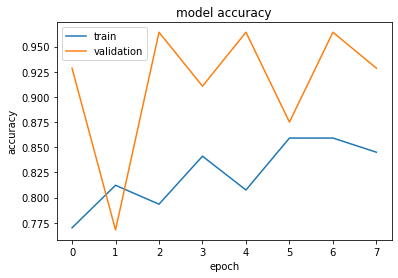

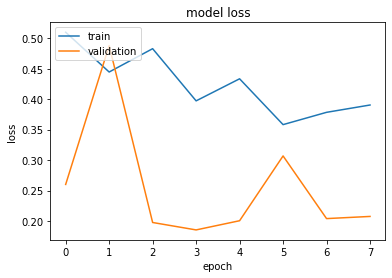

In [22]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [23]:
model.save('cnn_Yes_No.h5')

# prediction

In [24]:
from keras.models import load_model
import numpy as np

In [25]:
import cv2

In [26]:
model=load_model('cnn_Yes_No.h5')

In [27]:
from skimage.transform import resize

In [28]:
def detect(frame):
    try:
        img= resize(frame,(64,64))
        #print(img)
        img= np.expand_dims(img,axis=0)
        #print(img)
        if(np.max(img)>1):
            img= img/255.0
        prediction= model.predict(img)
        print(prediction)
        print(model.predict_classes(img))
    except AttributeError:
        print("No tumor found")
        

In [29]:
frame= cv2.imread(r'C:\Users\asus\Desktop\uploads\dataset\test_set\yes\test_set\no\1 no.jpg')
data= detect(frame)

No tumor found


# conclusion: